## Setup and Data Import

In [1]:
import sys
sys.path.insert(0, '..')

from joblib import dump, load

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

import sklearn.model_selection as ms
from sklearn import preprocessing as pp
from sklearn.linear_model import \
    LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import \
    RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix

import imblearn

import Functions as fxns

import matplotlib.pyplot as plt
plt.style.use('dark_background')

# some pkl models were made with a previous version of sklearn
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [2]:
providers = load('./data/Iteration_1/Providers_Final_Iteration_1.pkl')
providers.set_index('Provider', inplace=True)

In [3]:
X = providers.drop('PotentialFraud', axis=1)
y = providers.PotentialFraud

## Pre-processing

In [4]:
# # 70/30 split gives roughly the same baseline model results
# # as 80/20 and 90/10, but saves grid_search time

X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size = 0.3, random_state = 0, stratify=y)

In [5]:
# # Scale only the training data to avoid data leakage
# # MinMax performed better or about the same as StandardScaler,
# # RobustScaler, and Normalize on most models

scaler = pp.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [6]:
# Upsample for K-nearest Neighbors and Gradient Boosting

oversample = imblearn.over_sampling.SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

In [7]:
# # Stratify folds so that classes always have the same sample ratio
# # n_splits=10 to maximize testing for this small dataset

skfold = ms.StratifiedKFold(n_splits=10, random_state=0, shuffle=True);

In [8]:
def model_results(model,
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
        train_recall = recall_score(y_train, model.predict(X_train))
        test_recall = recall_score(y_test, model.predict(X_test))
        
        print('Model details:', model, '\n')
        print('Train Set Recall Score:',
              f'{round(train_recall, 4) * 100}%')
        print('Test Set Recall Score:',
              f'{round(test_recall, 4) * 100}%')
        print('\nTrain Set Confusion Matrix:\n',
              confusion_matrix(y_train, model.predict(X_train)))
        print('Test Set Confusion Matrix:\n',
              confusion_matrix(y_test, model.predict(X_test)))

## Logistic Regression

### Models

In [9]:
# # baseline model

# L1 penalty for feature selection, liblinear solver faster than saga
# logRegCV = \
#     LogisticRegressionCV(penalty='l1', solver='liblinear', cv=skfold,
#                          class_weight='balanced', scoring='recall',
#                          random_state=0, n_jobs=(-1), verbose=1)

# logRegCV.fit(X_train, y_train)

# # dump(logRegCV, './data/logRegCV.pkl')

logRegCV = load('./data/Iteration_1/logRegCV.pkl')
model_results(logRegCV)

Model details: LogisticRegressionCV(class_weight='balanced',
                     cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
                     n_jobs=-1, penalty='l1', random_state=0, scoring='recall',
                     solver='liblinear', verbose=1) 

Train Set Recall Score: 91.81%
Test Set Recall Score: 91.45%

Train Set Confusion Matrix:
 [[2344 1089]
 [  29  325]]
Test Set Confusion Matrix:
 [[1028  443]
 [  13  139]]


In [10]:
# # grid search with accuracy scoring metric

# logRegGSAccuracy = ms.GridSearchCV(logRegModel, param_grid=params,
#                                    cv=skfold, n_jobs=(-1), verbose=1)

# logRegAccuracy = logRegGSAccuracy.fit(X_train, y_train)
# bestLogRegAccuracy = logRegAccuracy.best_estimator_

# # dump(bestLogRegAccuracy, './data/bestLogRegAccuracy.pkl')

bestLogRegAccuracy = load('./data/Iteration_1/bestLogRegAccuracy.pkl')
model_results(bestLogRegAccuracy)

Model details: LogisticRegression(C=68.66488450042998, class_weight='balanced', n_jobs=-1,
                   penalty='l1', random_state=0, solver='liblinear', verbose=1) 

Train Set Recall Score: 91.53%
Test Set Recall Score: 82.89%

Train Set Confusion Matrix:
 [[2970  463]
 [  30  324]]
Test Set Confusion Matrix:
 [[1277  194]
 [  26  126]]


In [11]:
# # grid search with recall scoring metric

# # can't use scoring param, need to use recall_score()
# logRegModel = \
#     LogisticRegression(penalty='l1', solver='liblinear',
#                        class_weight='balanced', random_state=0,
#                        n_jobs=(-1), verbose=1)

# params = {'C': np.logspace(-2, 2, 50),
#           'max_iter': [100, 500, 1000]}

# logRegGS = ms.GridSearchCV(logRegModel, param_grid=params,
#                            scoring='recall', cv=skfold, verbose=1)

# logReg = logRegGS.fit(X_train, y_train)
# bestLogReg = logReg.best_estimator_

# # dump(bestLogReg, './data/bestLogReg.pkl')

bestLogReg = load('./data/Iteration_1/bestLogReg.pkl')
model_results(bestLogReg)

Model details: LogisticRegression(C=0.0655128556859551, class_weight='balanced', n_jobs=-1,
                   penalty='l1', random_state=0, solver='liblinear', verbose=1) 

Train Set Recall Score: 92.66%
Test Set Recall Score: 92.11%

Train Set Confusion Matrix:
 [[2491  942]
 [  26  328]]
Test Set Confusion Matrix:
 [[1087  384]
 [  12  140]]


### Results

In [12]:
coefficients = pd.DataFrame(bestLogReg.coef_.T, index=X.columns
                           ).rename(columns = {0:'Coefficient'}
                           ).abs().sort_values(by='Coefficient',
                                               ascending=False)
coefficients[coefficients.Coefficient > 0]

,Coefficient
PatientsPerOthPhys,7.691565
Ratio_ClaimsPerPatient,3.215364
IP_Count_UniquePatients,3.138851
Perc_Outpatient,1.847467
DualPatientProvider,1.636980
OP_Perc_MultHosp,0.674412
IP_Mean_InsReimbursementRatio,0.379315
OP_Count_UniqueState,0.228130
IP_Perc_HeartFailure_Chronic,0.143150
Perc_MultHospAttPhys,0.057042


## K-nearest Neighbors

In [13]:
# # baseline model

knn = KNeighborsClassifier()

# knnFit = knn.fit(X_train, y_train)

# dump(knnFit, './data/Iteration_1/knnFit.pkl')

knnFit = load('./data/Iteration_1/knnFit.pkl')
model_results(knnFit)

Model details: KNeighborsClassifier() 

Train Set Recall Score: 61.58%
Test Set Recall Score: 48.68%

Train Set Confusion Matrix:
 [[3306  127]
 [ 136  218]]
Test Set Confusion Matrix:
 [[1396   75]
 [  78   74]]


In [14]:
# # grid search

# params = {'n_neighbors': [5, 10, 30, 70, 100, 500, 1500],
#           'weights': ['uniform','distance']}

# knnGS = \
#     ms.GridSearchCV(knn, param_grid=params,
#                           cv=skfold, n_jobs=(-1), verbose = 1,
#                           return_train_score = True,
#                           scoring = 'recall')

# knnFit = knnGS.fit(X_train_SMOTE, y_train_SMOTE)

# bestKNN = knnFit.best_estimator_
# dump(bestKNN, './data/Iteration_1/bestKNN.pkl')

bestKNN = load('./data/Iteration_1/bestKNN.pkl')
model_results(bestKNN)

Model details: KNeighborsClassifier(weights='distance') 

Train Set Recall Score: 100.0%
Test Set Recall Score: 92.11%

Train Set Confusion Matrix:
 [[3433    0]
 [   0  354]]
Test Set Confusion Matrix:
 [[1064  407]
 [  12  140]]


## Gaussian Naive Bayes

In [15]:
# # baseline model

# gnbModel = GaussianNB()

# gnbFit = gnbModel.fit(X_train, y_train)
# dump(gnbFit, './data/Iteration_1/gnbFit.pkl')

gnbFit = load('./data/Iteration_1/gnbFit.pkl')
model_results(bestKNN)

Model details: KNeighborsClassifier(weights='distance') 

Train Set Recall Score: 100.0%
Test Set Recall Score: 92.11%

Train Set Confusion Matrix:
 [[3433    0]
 [   0  354]]
Test Set Confusion Matrix:
 [[1064  407]
 [  12  140]]


In [16]:
# # grid search

# params = {'var_smoothing': [0.001, 0.01, 0.1]}

# gnbModelGS = ms.GridSearchCV(gnbModel, param_grid=params,
#                              scoring='recall', cv=skfold,
#                              n_jobs=(-1), verbose=1
#                             ).fit(X_train, y_train)

# bestGNB = gnbModelGS.best_estimator_
# dump(bestGNB, './data/Iteration_1/bestGNB.pkl')

bestGNB = load('./data/Iteration_1/bestGNB.pkl')
model_results(bestGNB)

Model details: GaussianNB(var_smoothing=0.01) 

Train Set Recall Score: 90.96%
Test Set Recall Score: 90.13%

Train Set Confusion Matrix:
 [[2488  945]
 [  32  322]]
Test Set Confusion Matrix:
 [[1104  367]
 [  15  137]]


## Tree Models

### Random Forest

In [17]:
# # baseline model

# randForestModel = RandomForestClassifier(class_weight='balanced', random_state=0)

# randForestFit = randForestModel.fit(X_train, y_train)

# dump(randForestFit, './data/Iteration_1/randForest.pkl')
randForest = load('./data/Iteration_1/randForest.pkl')
model_results(randForest)

Model details: RandomForestClassifier(class_weight='balanced', random_state=0) 

Train Set Recall Score: 100.0%
Test Set Recall Score: 40.129999999999995%

Train Set Confusion Matrix:
 [[3433    0]
 [   0  354]]
Test Set Confusion Matrix:
 [[1456   15]
 [  91   61]]


#### Results

In [18]:
best_randForest = load('./data/Iteration_1/best_randForest.pkl')
model_results(best_randForest)

Model details: RandomForestClassifier(class_weight='balanced', max_depth=5.0, max_features=3,
                       random_state=0) 

Train Set Recall Score: 92.94%
Test Set Recall Score: 92.75999999999999%

Train Set Confusion Matrix:
 [[2899  534]
 [  25  329]]
Test Set Confusion Matrix:
 [[1260  211]
 [  11  141]]


In [19]:
# # best model with balanced_subsample class weight instead of balanced

# bestRF_bal_sub = \
#     RandomForestClassifier(class_weight='balanced_subsample',
#                            max_depth=5, max_features=3,
#                            random_state=0)

# bestRF_bal_sub_Fit = bestRF_bal_sub.fit(X_train, y_train)
# dump(bestRF_bal_sub_Fit, './data/Iteration_1/bestRF_bal_sub.pkl')

bestRF_bal_sub = load('./data/Iteration_1/bestRF_bal_sub.pkl')
model_results(bestRF_bal_sub)

Model details: RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       max_features=3, random_state=0) 

Train Set Recall Score: 93.5%
Test Set Recall Score: 88.16000000000001%

Train Set Confusion Matrix:
 [[2951  482]
 [  23  331]]
Test Set Confusion Matrix:
 [[1279  192]
 [  18  134]]


#### Feature Importances

Top 10: ['IP_Mean_InscClaimAmtReimbursed', 'IP_Mean_ClaimCost', 'IP_Count_UniquePatients', 'PatientsPerAttPhys', 'IP_Mean_AdmitDuration', 'IP_Mean_ClaimDuration', 'PatientsPerOthPhys', 'DualPatientProvider', 'PatientsPerOperPhys', 'IP_Mean_AgeAtClaim']


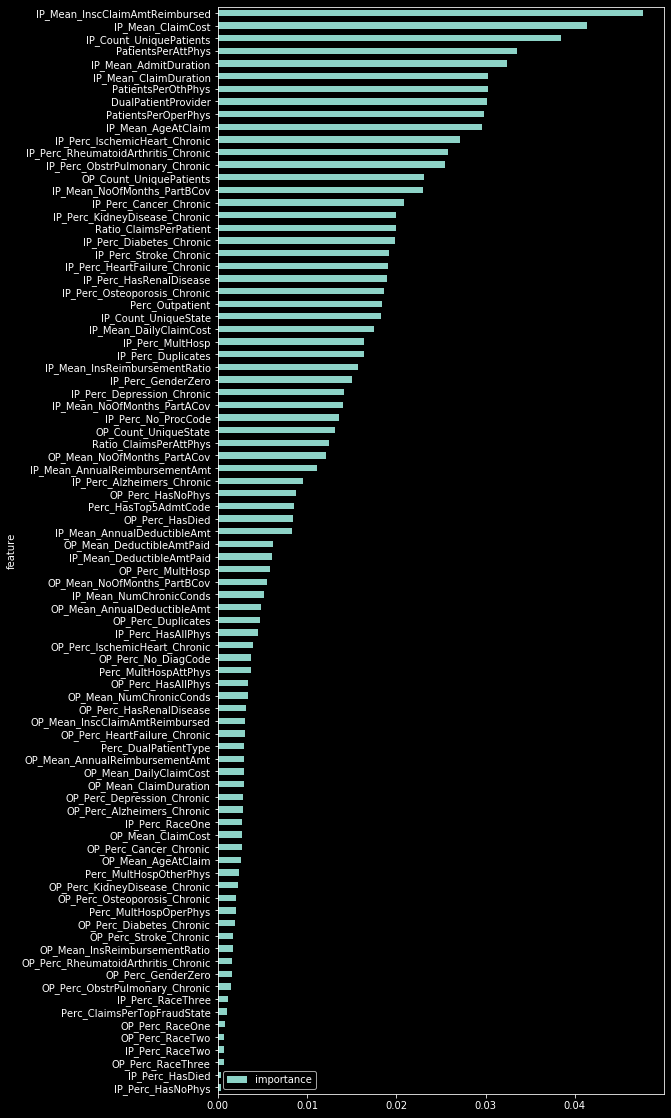

In [20]:
fxns.feature_importances(best_randForest, X)

#### Grid Searches

In [21]:
# params = {'n_estimators': [100, 500, 750],
#           'max_depth': [2, 5, 8],
#           'max_features': [2, 3, 5]}

# randForestGS = ms.GridSearchCV(randForestModel, param_grid=params,
#                                     scoring='recall', cv=skfold,
#                                     n_jobs=(-1), verbose=1)

# randForest = randForestGS.fit(X_train, y_train)

# bestRandForest = randForest.best_estimator_
# dump(bestRandForest, './data/Iteration_1/bestRandForest.pkl')

In [22]:
# 70/30 train/test split, MinMaxScaler(), skfold=10

# params = {'n_estimators': [100, 500, 1500],
#           'max_depth': [2, 5, 8]}
# RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=500,
#                        random_state=0)
# 0.8870056497175142
# 0.875
# RandomForestClassifier(class_weight='balanced_subsample', max_depth=2,
#                        n_estimators=500, random_state=0)
# 0.884180790960452
# 0.875

# params = {'n_estimators': [100, 500, 750],
#           'max_depth': [2, 5, 8],
#           'min_samples_split': [2, 3, 5]}
# RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=500,
#                        random_state=0)
# 0.8870056497175142
# 0.875

# params = {'n_estimators': [100, 500, 750],
#           'max_depth': [2, 5, 8],
#           'max_features': [2, 3, 5]}
# RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=3,
#                        random_state=0)
# 0.8615819209039548
# 0.8618421052631579


# 90/10 train/test split, MinMaxScaler, skfold=10

# params = {'n_estimators': [100, 500, 750],
#           'max_depth': [2, 5, 8],
#           'max_features': [2, 3, 5]}
# RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=2,
#                        n_estimators=750, random_state=0)
# 0.8637362637362638
# 0.8235294117647058

### Gradient Boosting

In [23]:
# # baseline model with upsampling

# gradBoostModel = \
#     GradientBoostingClassifier(max_features='auto', random_state=0)

# gradBoostModelFit = gradBoostModel.fit(X_train_SMOTE, y_train_SMOTE)
# dump(gradBoostModelFit, './data/Iteration_1/gradBoostModelFit.pkl')

gradBoostModel = load('./data/Iteration_1/gradBoostModelFit.pkl')
model_results(gradBoostModel)

Model details: GradientBoostingClassifier(max_features='auto', random_state=0) 

Train Set Recall Score: 84.75%
Test Set Recall Score: 74.33999999999999%

Train Set Confusion Matrix:
 [[3323  110]
 [  54  300]]
Test Set Confusion Matrix:
 [[1396   75]
 [  39  113]]


In [24]:
# params = {'n_estimators': [100, 1000, 5000],
#           'learning_rate':[0.05, 0.1, 0.5],
#           'min_samples_leaf': [1, 3, 5],
#           'max_depth': np.arange(1, 20, 8),
#           'max_features' : np.arange(1, 20, 8)}

# gradBoostGS = ms.GridSearchCV(gradBoostModel, param_grid=params,
#                                     scoring='recall', cv=skfold,
#                                     n_jobs=-1, verbose=1)

# gradBoost = gradBoostGS.fit(X_train_SMOTE, y_train_SMOTE)

# bestGradBoost = gradBoost.best_estimator_
# dump(bestGradBoost, './data/bestGradBoost.pkl')

bestGradBoost = load('./data/Iteration_1/bestGradBoost.pkl')
model_results(bestGradBoost)

Model details: GradientBoostingClassifier(max_depth=9, max_features=1, min_samples_leaf=3,
                           n_estimators=1000, random_state=0) 

Train Set Recall Score: 100.0%
Test Set Recall Score: 59.870000000000005%

Train Set Confusion Matrix:
 [[3433    0]
 [   0  354]]
Test Set Confusion Matrix:
 [[1426   45]
 [  61   91]]


In [25]:
# params = {'n_estimators': [100,500,1000,2500,5000,6000],
#                 'learning_rate':[0.01,0.05,0.08,0.1, 0.25],
#                 'max_depth': np.arange(2, 21, 3),
#                 'min_samples_split': np.arange(2, 13, 2),
#                 'min_samples_leaf' : np.arange(2, 13, 2)}

# gradBoostRS = ms.RandomizedSearchCV(gradBoostModel,
#                                     param_distributions=params,
#                                     cv=skfold, scoring = 'recall',
#                                     return_train_score = True,
#                                     verbose=1, n_jobs=(-1))
# gradBoostRSfit = gradBoostRS.fit(X_train_SMOTE, y_train_SMOTE)

# bestGradBoostRS = gradBoostRSfit.best_estimator_
# dump(bestGradBoostRS, './data/bestGradBoostRS.pkl')

bestGradBoostRS = load('./data/Iteration_1/bestGradBoostRS.pkl')
model_results(bestGradBoostRS)

Model details: GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                           max_features='auto', min_samples_leaf=2,
                           min_samples_split=6, n_estimators=2500,
                           random_state=0) 

Train Set Recall Score: 100.0%
Test Set Recall Score: 62.5%

Train Set Confusion Matrix:
 [[3433    0]
 [   0  354]]
Test Set Confusion Matrix:
 [[1427   44]
 [  57   95]]


## Support Vector Machine

In [26]:
# # baseline model

svmModel = SVC(random_state=0, class_weight='balanced')

# svmFit = svmModel.fit(X_train, y_train)
# dump(svmFit, './data/Iteration_1/svm.pkl')

svm = load('./data/Iteration_1/svm.pkl')
model_results(svm)

Model details: SVC(class_weight='balanced', random_state=0) 

Train Set Recall Score: 93.78999999999999%
Test Set Recall Score: 92.11%

Train Set Confusion Matrix:
 [[2724  709]
 [  22  332]]
Test Set Confusion Matrix:
 [[1175  296]
 [  12  140]]


In [27]:
# # grid search

# params = {'C': np.logspace(-3, 2, 50)}

# svmGS = ms.GridSearchCV(svmModel, param_grid=params, scoring='recall',
#                         cv=skfold, n_jobs=(-1), verbose=1).fit(X_train, y_train)

# bestSVM = svmGS.best_estimator_
# dump(bestSVM, './data/Iteration_1/bestSVM.pkl')

bestSVM = load('./data/Iteration_1/bestSVM.pkl')
model_results(bestSVM)

Model details: SVC(C=0.22229964825261955, class_weight='balanced', random_state=0) 

Train Set Recall Score: 92.94%
Test Set Recall Score: 92.11%

Train Set Confusion Matrix:
 [[2439  994]
 [  25  329]]
Test Set Confusion Matrix:
 [[1074  397]
 [  12  140]]


In [28]:
# # more detailed grid search, worse results

# params = {'C': np.logspace(-3, 2, 50),
#           'kernel': ['rbf', 'linear'],
#           'degree': [1, 3, 5],
#           'gamma': ['scale', 'auto']}

# ms.GridSearchCV(svmModel, param_grid=params, scoring='recall',
#                 cv=skfold, n_jobs=(-1), verbose=1).fit(X_train, y_train)

# Model details: SVC(C=0.06866488450043001, class_weight='balanced', degree=1, kernel='linear',
#     random_state=0) 

# Train Set Recall Score: 93.22%
# Test Set Recall Score: 92.11%

# Train Set Confusion Matrix:
#  [[2339 1094]
#  [  24  330]]
# Test Set Confusion Matrix:
#  [[1030  441]
#  [  12  140]]